# Train FCN for semantic segmentation

You must only define model structure and choose loss function. \
After model will work, optionally add some augmentation to improve results

## Ideas for extra work

* Build segmentation model using pretrained backbone model from [SMP](https://github.com/qubvel/segmentation_models.pytorch) and compare results with obtained from your model
* Combine two different loss e.g. BCE and [IoULoss](https://smp.readthedocs.io/en/latest/losses.html#jaccardloss)
* Add augmentation from [Albumentation](https://albumentations.ai/)

## Setup

In [1]:
import os
import glob
import typing
import random
import warnings

import tqdm
import torch
import wandb
import numpy
import PIL.Image
import torchvision
import albumentations
import sklearn.metrics
import torch.utils.data
import torchvision.tv_tensors
import matplotlib.pyplot as plt
import torchvision.transforms.v2
import segmentation_models_pytorch

warnings.filterwarnings("ignore")

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [2]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

## Data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.

In [3]:
! wget http://fmb.images.gan4x4.ru/hse/midv500p.zip
! unzip -q midv500p.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Dataset

In [4]:
# To bypass error on corrupted files: https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images
# ImageFile.LOAD_TRUNCATED_IMAGES = False

class MaskDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        train = True,
        path = "midv500p",
        transform = None, # for image only
        transforms = None, # for image and mask
        target_transform = None # for mask only
    ):
        self.masks = []
        self.images = []
        self.transform = transform
        self.transforms = transforms
        self.target_transform = target_transform

        path += ("/train" if train else "/val")
        for filename in glob.glob(path + "/image/*"):
            self.images.append(PIL.Image.open(filename))
            self.masks.append(PIL.Image.open(filename.replace("image", "mask").replace("jpg", "png")))

    def __getitem__(self, i: int) -> typing.Tuple[torchvision.tv_tensors.Image, torchvision.tv_tensors.Mask]:
        img, mask = self.images[i], self.masks[i]
        if self.transform is not None:
            img = self.transform(img)
        if self.transforms is not None:
            img = torchvision.tv_tensors.Image(img)
            mask = torchvision.tv_tensors.Mask(mask)
            img, mask = self.transforms(img, mask)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        return img, mask * 1.

    def __len__(self) -> int:
        return len(self.images)
    
    def load_all(self):
        images, masks = [ ], [ ]
        for record in self:
            images.append(record[0])
            masks.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), torch.stack(masks)
        except: return images, masks
    
    def channel_stats(self):
        images, _ = self.load_all()
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

In [5]:
transforms = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((224, 224)),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

mean, std = MaskDataset(train = True, transforms = transforms).channel_stats()
mean, std

(tensor([0.5574, 0.4638, 0.3746]), tensor([0.2636, 0.2555, 0.2775]))

In [6]:
transforms = torchvision.transforms.v2.Compose([
    transforms,
    torchvision.transforms.v2.Normalize(mean, std)
])
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

trainset = MaskDataset(train = True, transforms = transforms)
valset = MaskDataset(train = False, transforms = transforms)

### Show images

In [7]:
def show_image(ax, image, **kwargs):
    ax.axis('off')
    image = denormalize(image).permute(1, 2, 0).detach().cpu()
    ax.imshow((image.numpy() * 255).astype(numpy.uint8), **kwargs)

def show_mask(ax, mask, **kwargs):
    ax.axis('off')
    mask = mask.permute(1, 2, 0).detach().cpu()
    if 'cmap' not in kwargs: kwargs['cmap'] = 'gray'
    ax.imshow((mask.numpy() * 255).astype(numpy.uint8), vmin = 0, vmax = 255, **kwargs)

def show_image_with_mask(ax, image, mask):
    show_image(ax, image)
    show_mask(ax, mask, cmap = None, alpha = 0.66)

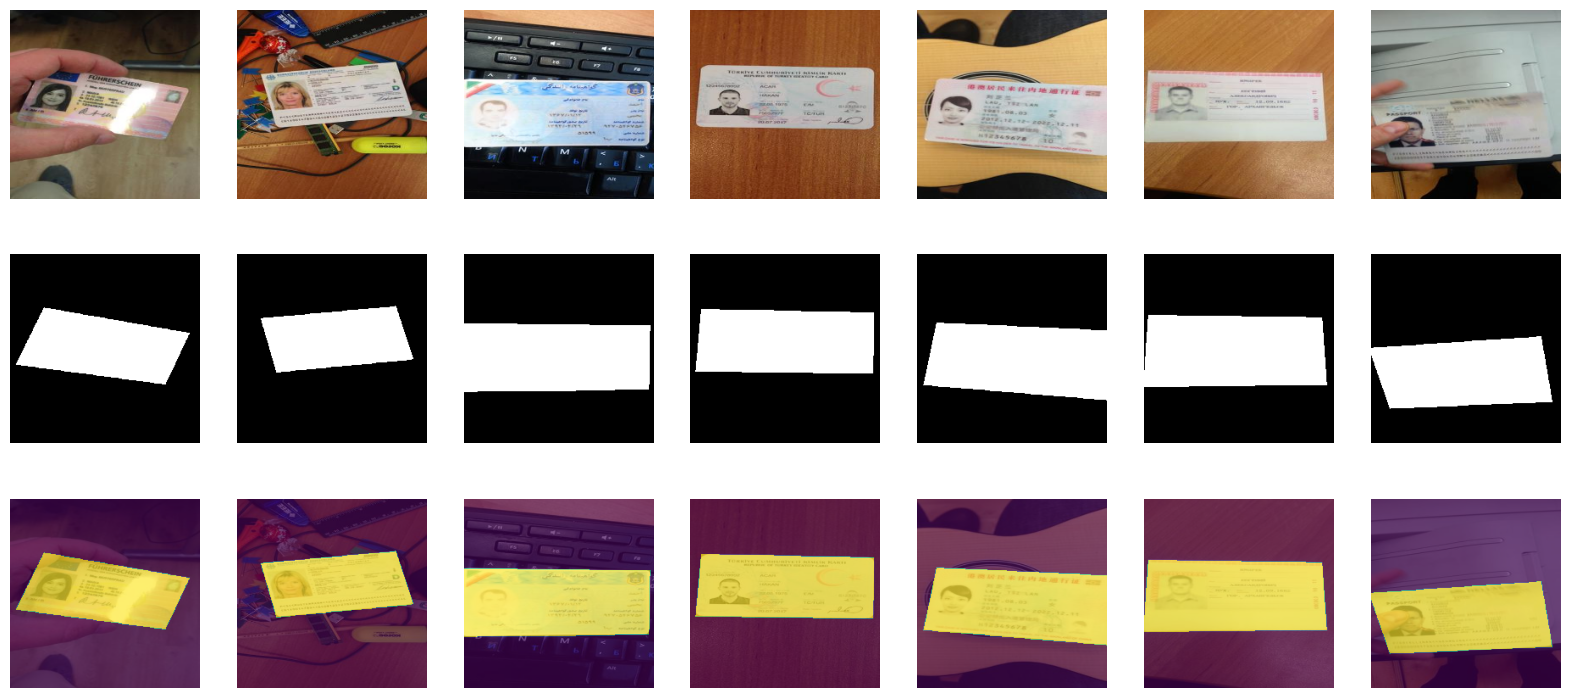

In [8]:
def display_examples(dataset: torch.utils.data.Dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 7, shuffle = True)
    images, masks = next(iter(loader))
    fig, axes = plt.subplots(3, 7, figsize = (20, 9))
    for ax, image, mask in zip(axes[0], images, masks): show_image(ax, image)
    for ax, image, mask in zip(axes[1], images, masks): show_mask(ax, mask)
    for ax, image, mask in zip(axes[2], images, masks): show_image_with_mask(ax, image, mask)

# Display some samples from each dataset
fix_random()
plt.rcParams["figure.figsize"] = (20, 10)
display_examples(trainset)

## Train

### Model structure

Use [UNet](https://arxiv.org/pdf/1505.04597.pdf) - like structure.
But  decrease number of layers for simplicity.
Original images has 224x224 resolution.

In [9]:
class UnetConv(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, convolutions: int = 2):
        super().__init__()
        # Use padding for simplicity. The worst that can happen is bad quality near the edges
        modules = [ torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), torch.nn.ReLU() ]
        for _ in range(convolutions - 1):
            modules.append(torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1))
            modules.append(torch.nn.ReLU())
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.model(input)

assert UnetConv(3, 64)(torch.rand(5, 3, 572, 572)).shape == (5, 64, 572, 572)

In [10]:
class DownsampleBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = UnetConv(in_channels, out_channels)
        self.pool = torch.nn.MaxPool2d(2)
    
    def forward(self, input: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        features = self.conv(input)
        output = self.pool(features)
        return features, output

assert DownsampleBlock(3, 64)(torch.rand(5, 3, 572, 572))[0].shape == (5, 64, 572, 572)
assert DownsampleBlock(3, 64)(torch.rand(5, 3, 572, 572))[1].shape == (5, 64, 286, 286)

In [11]:
class UpsampleBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_conv = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2)
        self.conv = UnetConv(2 * out_channels, out_channels)
    
    def forward(self, input: torch.Tensor, features: torch.Tensor) -> torch.Tensor:
        features = torch.cat([ self.up_conv(input), features ], dim = 1)
        return self.conv(features)

assert UpsampleBlock(128, 64)(torch.rand(5, 128, 286, 286), torch.rand(5, 64, 572, 572)).shape == (5, 64, 572, 572)

In [12]:
class MiniUnet(torch.nn.Module):
    def __init__(self, in_channels: int = 3, layers: int = 2, start_channels: int = 16):
        super().__init__()
        channels = [ in_channels, *[ (2 ** i) * start_channels for i in range(layers + 1) ] ]
        self.downsample_blocks = torch.nn.ModuleList([ DownsampleBlock(*c) for c in zip(channels[:-2], channels[1:-1]) ])
        self.bottom = UnetConv(channels[-2], channels[-1])
        channels.reverse()
        self.upsample_blocks = torch.nn.ModuleList([ UpsampleBlock(*c) for c in zip(channels[:-2], channels[1:-1]) ])
        self.output = torch.nn.Sequential(torch.nn.Conv2d(channels[-2], 1, kernel_size = 1), torch.nn.Sigmoid())

    def forward(self, input: torch.Tensor):
        feature_maps = [ ]
        for downsample_block in self.downsample_blocks:
            features, input = downsample_block(input)
            feature_maps.insert(0, features)
        input = self.bottom(input)
        for upsample_block, feature_map in zip(self.upsample_blocks, feature_maps):
            input = upsample_block(input, feature_map)
        return self.output(input)
    
assert MiniUnet()(torch.rand(5, 3, 224, 224)).shape == (5, 1, 224, 224)

### Loss

In [13]:
def unet_loss(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.binary_cross_entropy(input, target, reduction = 'sum')

### Metrics

In [14]:
def unet_metrics(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # Segmentation is basically just per-pixel classification
    scores = input.flatten().detach().cpu().numpy()
    preds = (scores >= 0.5).astype(numpy.int8)
    targets = target.flatten().detach().cpu().numpy().astype(numpy.int8)
    return {
        'Accuracy':      sklearn.metrics.accuracy_score (targets, preds),
        'AUC-ROC':       sklearn.metrics.roc_auc_score  (targets, scores),
        'Precision':     sklearn.metrics.precision_score(targets, preds, zero_division = 0),
        'Recall':        sklearn.metrics.recall_score   (targets, preds, zero_division = 0),
        'F1-score':      sklearn.metrics.f1_score       (targets, preds, zero_division = 0),
        'Jaccard score': sklearn.metrics.jaccard_score  (targets, preds, zero_division = 0)
    }

### Training function

In [31]:
def lr_scheduler(epoch: int):
    if epoch < 15: return 1
    if epoch < 20: return 0.1
    return 0.001

def train(
    model: MiniUnet,
    name: str,
    learning_rate: float = 1e-3,
    n_epochs: int = 25,
    loss_func: typing.Callable[[torch.Tensor], torch.Tensor] = unet_loss,
    metrics_func: typing.Callable[[torch.Tensor], torch.Tensor] = unet_metrics
) -> MiniUnet:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size = len(valset), shuffle = False)

    wandb.init(project = "CV-HW-9", name = name, anonymous = "allow")
    wandb.watch(model, log = "all")
    for _ in tqdm.trange(n_epochs):
        train_loss = 0
        for (images, masks) in train_loader:
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            output = model(images.to(device)) # Get predictions
            loss = loss_func(output, masks.to(device)) # Calculate loss
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            wandb.log({ 'Train batch loss': loss.item() / images.shape[0] })
            train_loss += loss.item()
            
        model.eval() # Enter eval mode
        images, masks = next(iter(val_loader))
        with torch.no_grad():
            outputs = model(images.to(device))
            val_loss = loss_func(outputs, masks.to(device)).detach().cpu().item()
        val_metrics = metrics_func(outputs, masks)
        
        scheduler.step()
        wandb.log({ 'Train loss': train_loss / len(trainset), 'Val Loss': val_loss / len(valset), **val_metrics })

    wandb.finish(quiet = True)
    return model.cpu()

## Display results

In [16]:
def display_results(model: torch.nn.Module, dataset: torch.utils.data.Dataset, threshold: float = 0.5):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 7, shuffle = True)
    images, masks = next(iter(loader))
    outputs = (model(images) > threshold)
    fig, axes = plt.subplots(5, 7, figsize = (15, 10))
    for ax, image, mask, output in zip(axes[0], images, masks, outputs): show_image(ax, image)
    for ax, image, mask, output in zip(axes[1], images, masks, outputs): show_mask(ax, mask)
    for ax, image, mask, output in zip(axes[2], images, masks, outputs): show_mask(ax, output)
    for ax, image, mask, output in zip(axes[3], images, masks, outputs): show_image_with_mask(ax, image, mask)
    for ax, image, mask, output in zip(axes[4], images, masks, outputs): show_image_with_mask(ax, image, output)

## 2 layers, 16 channels

In [ ]:
fix_random()
model_2_16 = train(MiniUnet(layers = 2, start_channels = 16), 'MiniUnet(2, 16)')
fix_random()
display_results(model_2_16, valset)

## 2 layers, 32 channels

In [ ]:
fix_random()
model_2_32 = train(MiniUnet(layers = 2, start_channels = 32), 'MiniUnet(2, 32)')
fix_random()
display_results(model_2_32, valset)

## 2 layers, 64 channels

CUDA out of memory 😭

## 3 layers, 16 channels

In [ ]:
fix_random()
model_3_16 = train(MiniUnet(layers = 3, start_channels = 16), 'MiniUnet(3, 16)')
fix_random()
display_results(model_3_16, valset)

## 3 layers, 32 channels

In [ ]:
fix_random()
model_3_32 = train(MiniUnet(layers = 3, start_channels = 32), 'MiniUnet(3, 32)')
fix_random()
display_results(model_3_32, valset)

## 4 layers, 16 channels

In [ ]:
fix_random()
model_4_16 = train(MiniUnet(layers = 4, start_channels = 16), 'MiniUnet(4, 16)')
fix_random()
display_results(model_4_16, valset)

## 4 layers, 32 channels

In [ ]:
fix_random()
model_4_32 = train(MiniUnet(layers = 4, start_channels = 32), 'MiniUnet(4, 32)')
fix_random()
display_results(model_4_32, valset)

## 4 layers, 64 channels

Original UNet \
CUDA out of memory 😭

## 5 layers, 32 channels

In [ ]:
fix_random()
model_5_32 = train(MiniUnet(layers = 5, start_channels = 32), 'MiniUnet(5, 32)')
fix_random()
display_results(model_5_32, valset)

In [40]:
num_params = sum(p.numel() for p in MiniUnet(layers = 5, start_channels = 32).parameters()) / 1e6
print('{} миллионов параметров'.format(num_params))

31.094497 миллионов параметров


## IoULoss

* Build segmentation model using pretrained backbone model from [SMP](https://github.com/qubvel/segmentation_models.pytorch) and compare results with obtained from your model
* Combine two different loss e.g. BCE and [IoULoss](https://smp.readthedocs.io/en/latest/losses.html#jaccardloss)
* Add augmentation from [Albumentation](https://albumentations.ai/)

In [29]:
def unet_loss_with_iou(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    iou = segmentation_models_pytorch.losses.JaccardLoss('binary', from_logits = False)(input, target)
    return (unet_loss(input, target) + iou * input.numel()) / 2 # make losses similar scale

Train batch loss,▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
Train batch loss,28285.50694


100%|██████████| 25/25 [05:51<00:00, 14.05s/it]


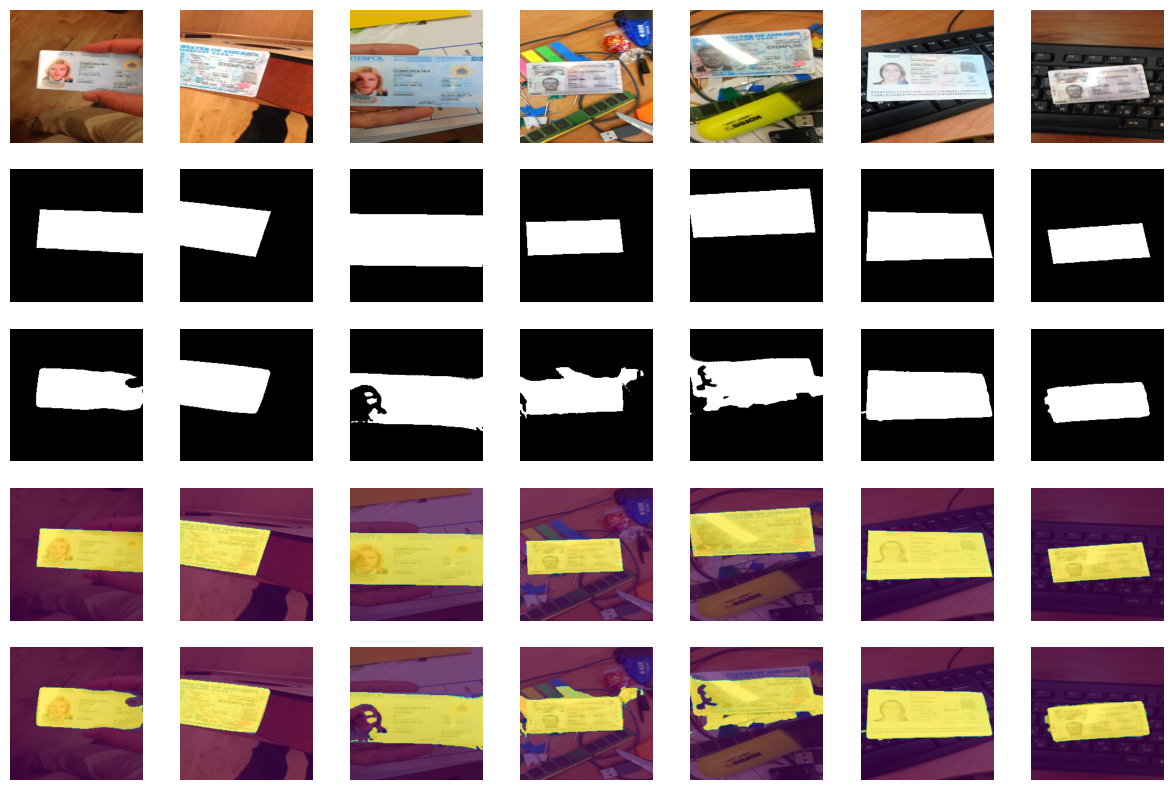

In [32]:
fix_random()
model_iou = train(MiniUnet(layers = 5, start_channels = 32), 'IoU loss', loss_func = unet_loss_with_iou)
fix_random()
display_results(model_iou, valset)

## Albumentations

## Pretrained